<a href="https://colab.research.google.com/github/mhmdbilal1016-lab/final-project/blob/main/project_IS_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne tensorflow scikit-learn matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 31.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import os

folder = "/content/drive/MyDrive/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001"
print("Files:", os.listdir(folder))

Files: ['S001R01.edf', 'S001R02.edf', 'S001R03.edf', 'S001R04.edf', 'S001R05.edf', 'S001R06.edf', 'S001R07.edf', 'S001R08.edf', 'S001R09.edf', 'S001R10.edf', 'S001R11.edf', 'S001R12.edf', 'S001R13.edf', 'S001R14.edf']


In [ ]:
import os

dataset_path = "/content/drive/MyDrive/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0"

subjects_missing = []
subjects_ok = {}

for subject in range(1, 110):
    folder = os.path.join(dataset_path, f"S{subject:03d}")

    if not os.path.exists(folder):
        subjects_missing.append(subject)
    else:
        edf_files = [f for f in os.listdir(folder) if f.endswith('.edf')]
        subjects_ok[subject] = len(edf_files)

print("Subjects downloaded:", len(subjects_ok))
print("Subjects missing:", subjects_missing)

Subjects downloaded: 109
Subjects missing: []


In [ ]:
import os
import numpy as np
import mne

DATASET_PATH = "/content/drive/MyDrive/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0"
OUTPUT_PATH = "/content/drive/MyDrive/mne_data/preprocessed"
os.makedirs(OUTPUT_PATH, exist_ok=True)

print("Dataset path:", DATASET_PATH)


Dataset path: /content/drive/MyDrive/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0


In [ ]:
from mne.io import read_raw_edf

def load_subject(subject, runs):
    folder = os.path.join(DATASET_PATH, f"S{subject:03d}")
    raws = []

    for r in runs:
        fname = os.path.join(folder, f"S{subject:03d}R{r:02d}.edf")
        raw = read_raw_edf(fname, preload=True, verbose=False)
        raws.append(raw)

    raw = mne.concatenate_raws(raws)
    return raw


In [ ]:
SESSION1 = list(range(3, 9))
SESSION2 = list(range(9, 15))

def process_subject(subject):
    print("Processing subject", subject)

    # Session 1
    raw1 = load_subject(subject, SESSION1)
    epochs1 = preprocess_raw(raw1)
    X1 = epochs1.get_data()
    y1 = np.full(len(X1), subject-1, dtype=int)

    # Session 2
    raw2 = load_subject(subject, SESSION2)
    epochs2 = preprocess_raw(raw2)
    X2 = epochs2.get_data()
    y2 = np.full(len(X2), subject-1, dtype=int)

    outpath = os.path.join(OUTPUT_PATH, f"S{subject:03d}.npz")
    np.savez_compressed(outpath, X1=X1, y1=y1, X2=X2, y2=y2)

    print("Saved:", outpath)


In [ ]:
import mne
fname = "/content/drive/MyDrive/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf"
raw = mne.io.read_raw_edf(fname, preload=False, verbose=False)
print(raw.ch_names)


['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']


In [ ]:
import mne

def select_eeg_channels(raw):
    """
    Keep EEG channels only, drop EOG/EMG/ECG/Misc,
    enforce consistent ordering, and apply 10-20 montage.
    """

    # --- 1. Pick only EEG channels
    eeg_raw = raw.copy().pick_types(eeg=True, eog=False, emg=False, ecg=False, misc=False)

    # --- 2. Force consistent channel order across all subjects
    # (EDF files sometimes store slightly different channel order)
    eeg_chs = sorted(eeg_raw.ch_names)
    eeg_raw.reorder_channels(eeg_chs)

    # --- 3. Apply standard EEG 10-20 montage (if channel names match)
    try:
        montage = mne.channels.make_standard_montage("standard_1020")
        eeg_raw.set_montage(montage, on_missing="ignore")
    except Exception as e:
        print("⚠ Could not apply 10–20 montage:", e)

    return eeg_raw


In [ ]:
def resample_eeg(raw, sfreq=128):
    """
    Resample EEG to a fixed sampling rate (default 128 Hz).
    Uses MNE's high-quality polyphase resampling.
    """
    raw = raw.copy().resample(sfreq, npad="auto")
    return raw


In [ ]:
EEG_CHANNELS_BCI = ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.',
                     'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..',
                     'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.',
                     'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.',
                     'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..',
                     'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.',
                     'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..',
                     'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']


In [ ]:
import os
import numpy as np
import mne

# Paths
DATASET_PATH = "/content/drive/MyDrive/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0"
OUTPUT_PATH = "/content/drive/MyDrive/mne_data/preprocessed"
os.makedirs(OUTPUT_PATH, exist_ok=True)

# EEG channel selection (BioSemi 64 standard)
EEG_CHANNELS = mne.channels.make_standard_montage('biosemi64').ch_names

# Preprocessing parameters
LOW_FREQ = 8.0           # Sensorimotor rhythm
HIGH_FREQ = 30.0
NOTCH_FREQ = 50          # Use 60 if US
RESAMPLE_RATE = 128
EPOCH_TMIN, EPOCH_TMAX = 0.5, 3.0  # seconds after stimulus

# Artifact threshold (µV) for peak-to-peak amplitude removal
ARTIFACT_THRESHOLD = 200

def preprocess_raw(raw):
    # Only keep channels present in this recording
    channels_to_pick = [ch for ch in EEG_CHANNELS_BCI if ch in raw.ch_names]
    raw.pick_channels(channels_to_pick)

    # Notch + bandpass filtering
    raw.notch_filter(50, verbose=False)
    raw.filter(8, 30, verbose=False)

    # Resample
    raw.resample(128, verbose=False)

    return raw



def epoch_data(raw: mne.io.BaseRaw, event_id=1):
    """Epoch data and normalize."""
    events, _ = mne.events_from_annotations(raw, verbose=False)
    epochs = mne.Epochs(
        raw, events, event_id=event_id,
        tmin=EPOCH_TMIN, tmax=EPOCH_TMAX,
        baseline=None, preload=True, verbose=False
    )
    X = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)

    # Remove extreme artifacts based on peak-to-peak amplitude
    ptp = X.max(axis=-1) - X.min(axis=-1)
    mask = np.all(ptp < ARTIFACT_THRESHOLD, axis=1)
    X = X[mask]

    # Channel-wise normalization (per epoch)
    X = (X - X.mean(axis=-1, keepdims=True)) / (X.std(axis=-1, keepdims=True) + 1e-6)

    return X

def process_subject(subject: int, runs: list):
    print(f"Processing subject {subject}")
    all_data = []
    all_labels = []

    for r in runs:
        fname = os.path.join(DATASET_PATH, f"S{subject:03d}", f"S{subject:03d}R{r:02d}.edf")
        raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)
        raw = preprocess_raw(raw)

        if raw is None:
            continue  # Skip this run

        X = epoch_data(raw)
        y = np.full(len(X), subject-1, dtype=int)
        all_data.append(X)
        all_labels.append(y)

    if len(all_data) == 0:
        print(f"No valid EEG data found for subject {subject}, skipping.")
        return

    X_concat = np.concatenate(all_data)
    y_concat = np.concatenate(all_labels)

    out_file = os.path.join(OUTPUT_PATH, f"S{subject:03d}.npz")
    np.savez_compressed(out_file, X=X_concat.astype(np.float32), y=y_concat)
    print(f"Saved: {out_file} (epochs: {len(X_concat)})")

# Example: process subject 1, runs 3–8
process_subject(1, runs=list(range(3, 9)))


Processing subject 1
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved: /content/drive/MyDrive/mne_data/preprocessed/S001.npz (epochs: 90)


In [ ]:
for subject in range(1, 110):
    process_subject(subject, runs=list(range(3, 15)))
import numpy as np
data = np.load("/content/drive/MyDrive/mne_data/preprocessed/S001.npz")
print(data['X'].shape, data['y'].shape)



Processing subject 1
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved: /content/dri

/tmp/ipython-input-2380781504.py:66: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-2380781504.py:66: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-2380781504.py:66: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-2380781504.py:66: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-2380781504.py:66: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-2380781504.py:66: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-2380781504.py:66: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-2380781504.py:66: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-2380781504.py:66: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-2380781504.py:66: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-2380781504.py:66: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-2380781504.py:66: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)


Saved: /content/drive/MyDrive/mne_data/preprocessed/S100.npz (epochs: 144)
Processing subject 101
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() 

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

PREP_PATH = "/content/drive/MyDrive/mne_data/preprocessed"

# Load all subjects
X_list, y_list = [], []
for fname in sorted(os.listdir(PREP_PATH)):
    if fname.endswith(".npz"):
        data = np.load(os.path.join(PREP_PATH, fname))
        # Some files may have X1, X2; we concatenate them
        X = np.concatenate([data['X1'], data['X2']], axis=0) if 'X1' in data else data['X']
        y = np.concatenate([data['y1'], data['y2']], axis=0) if 'y1' in data else data['y']
        X_list.append(X)
        y_list.append(y)

# Combine all subjects
X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

print("Total data shape:", X.shape, y.shape)

# Split into train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Total data shape: (19675, 64, 321) (19675,)
Train: (15740, 64, 321) Val: (1967, 64, 321) Test: (1968, 64, 321)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # float32 for GPU efficiency
        self.y = torch.tensor(y, dtype=torch.long)     # long for classification

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Return (channels, time) as input, label as target
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = EEGDataset(X_train, y_train)
val_dataset   = EEGDataset(X_val, y_val)
test_dataset  = EEGDataset(X_test, y_test)

# Create dataloaders
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

print("DataLoaders ready! Batches per epoch:", len(train_loader))


DataLoaders ready! Batches per epoch: 245


In [ ]:
import torch.nn as nn

class EEG_CNN_RNN(nn.Module):
    def __init__(self, n_channels=64, n_times=321, n_classes=109, rnn_hidden=128, rnn_layers=1):
        super().__init__()

        # ---------------- CNN ----------------
        self.cnn = nn.Sequential(
            nn.Conv1d(n_channels, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),   # halves time dimension
            nn.Dropout(0.3)
        )

        # ---------------- RNN ----------------
        self.rnn = nn.GRU(input_size=128, hidden_size=rnn_hidden, num_layers=rnn_layers,
                          batch_first=True, bidirectional=True)

        # ---------------- Fully connected ----------------
        self.fc = nn.Sequential(
            nn.Linear(rnn_hidden*2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        # x: (batch, channels, time)
        x = self.cnn(x)               # (batch, 128, time//2)
        x = x.permute(0, 2, 1)       # (batch, time//2, 128) for RNN
        out, _ = self.rnn(x)          # (batch, time//2, rnn_hidden*2)
        out = out[:, -1, :]           # take last time step
        out = self.fc(out)            # (batch, n_classes)
        return out


In [ ]:
import torch
from torch import nn, optim
from torch.cuda.amp import autocast, GradScaler

# ---------------- Device ----------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# ---------------- Model ----------------
n_channels, n_times, n_classes = X_train.shape[1], X_train.shape[2], 109
model = EEG_CNN_RNN(n_channels=n_channels, n_times=n_times, n_classes=n_classes)
model.to(device)

# ---------------- Loss & Optimizer ----------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ---------------- Mixed Precision ----------------
scaler = GradScaler()

# ---------------- Training Hyperparameters ----------------
EPOCHS = 30


Using device: cpu


/tmp/ipython-input-3555062702.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [ ]:
best_val_acc = 0.0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        with autocast():  # mixed precision
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = outputs.max(1)
        total += y_batch.size(0)
        correct += predicted.eq(y_batch).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    # ---------------- Validation ----------------
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = outputs.max(1)
            val_total += y_batch.size(0)
            val_correct += predicted.eq(y_batch).sum().item()

    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_eeg_cnn_rnn.pth")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-3241450853.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # mixed precision
/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/30 | Train Loss: 4.2573, Train Acc: 0.0363 | Val Acc: 0.0951
Epoch 2/30 | Train Loss: 3.0924, Train Acc: 0.1410 | Val Acc: 0.1881
Epoch 3/30 | Train Loss: 2.2489, Train Acc: 0.3073 | Val Acc: 0.3305
Epoch 4/30 | Train Loss: 1.5305, Train Acc: 0.5077 | Val Acc: 0.5994
Epoch 5/30 | Train Loss: 1.0617, Train Acc: 0.6527 | Val Acc: 0.8099
Epoch 6/30 | Train Loss: 0.7854, Train Acc: 0.7453 | Val Acc: 0.8236
Epoch 7/30 | Train Loss: 0.5987, Train Acc: 0.8060 | Val Acc: 0.7656
Epoch 8/30 | Train Loss: 0.4664, Train Acc: 0.8521 | Val Acc: 0.7870
Epoch 9/30 | Train Loss: 0.3830, Train Acc: 0.8760 | Val Acc: 0.8897
Epoch 10/30 | Train Loss: 0.3161, Train Acc: 0.8989 | Val Acc: 0.9461
Epoch 11/30 | Train Loss: 0.2822, Train Acc: 0.9101 | Val Acc: 0.9039
Epoch 12/30 | Train Loss: 0.2426, Train Acc: 0.9212 | Val Acc: 0.9532
Epoch 13/30 | Train Loss: 0.2079, Train Acc: 0.9334 | Val Acc: 0.8932
Epoch 14/30 | Train Loss: 0.1784, Train Acc: 0.9406 | Val Acc: 0.9451
Epoch 15/30 | Train Loss: 0.1

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Accuracy: 0.9787
Test F1-score: 0.9785


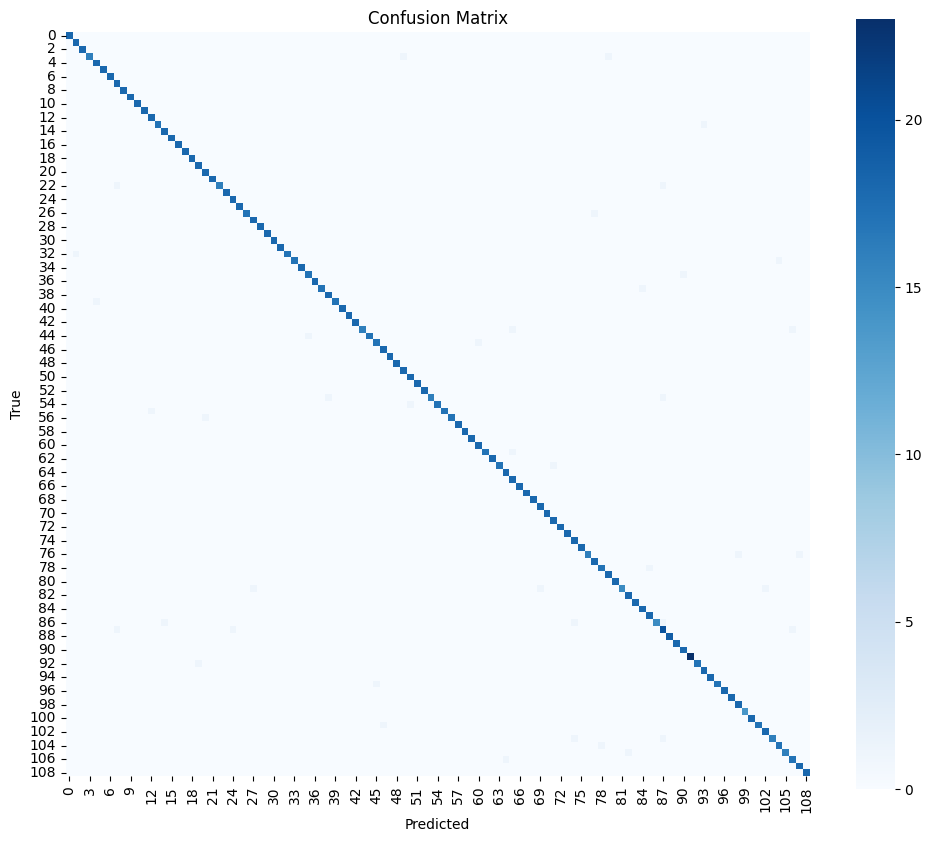

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load best model
model.load_state_dict(torch.load("best_eeg_cnn_rnn.pth", map_location=device))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# ---------------- Metrics ----------------
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1-score: {f1:.4f}")

# ---------------- Confusion Matrix ----------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap="Blues", square=True, cbar=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


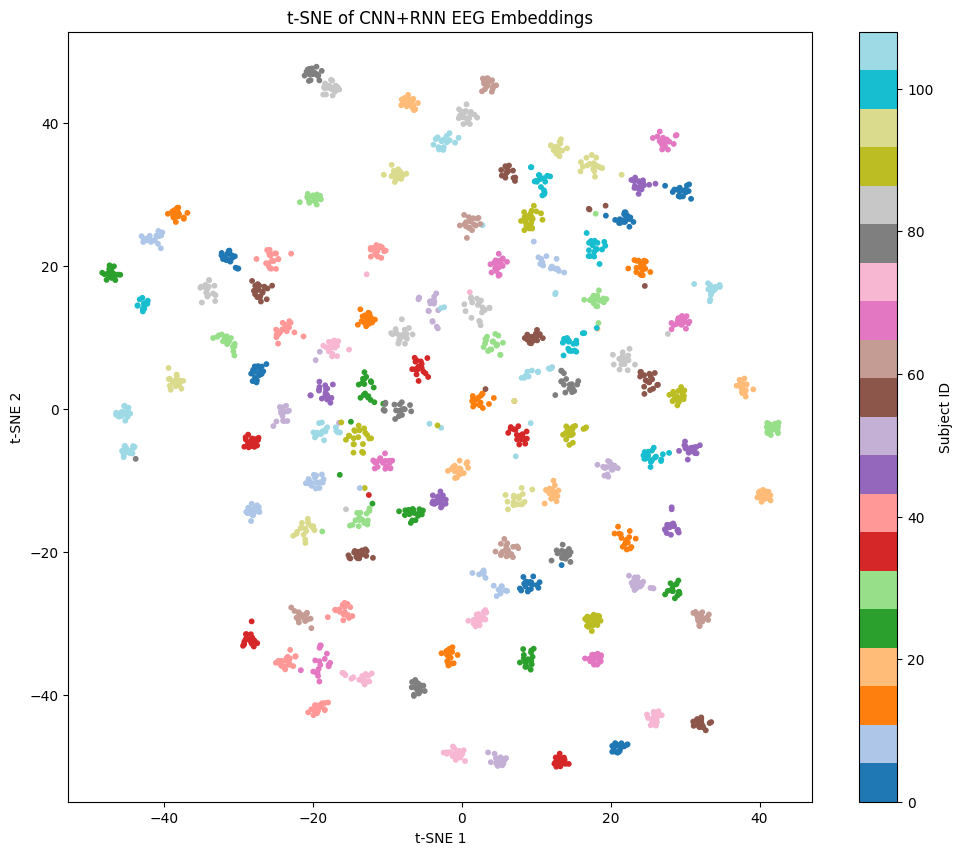

In [ ]:
from sklearn.manifold import TSNE

# Function to get embeddings from the model
def get_embeddings(model, loader):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            # Forward pass until penultimate layer
            x = model.cnn(X_batch)
            x = x.permute(0, 2, 1)
            x, _ = model.rnn(x)
            x = x[:, -1, :]  # last time step
            embeddings.append(x.cpu().numpy())
            labels.extend(y_batch.numpy())

    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.array(labels)
    return embeddings, labels

# Get embeddings for test set
embeddings, labels = get_embeddings(model, test_loader)

# t-SNE projection to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(12,10))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, cmap='tab20', s=10)
plt.colorbar(scatter, label='Subject ID')
plt.title("t-SNE of CNN+RNN EEG Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


In [ ]:
import numpy as np
data = np.load("/content/drive/MyDrive/mne_data/preprocessed/S001.npz")
print(data.files)  # shows all keys in the archive


['X', 'y']


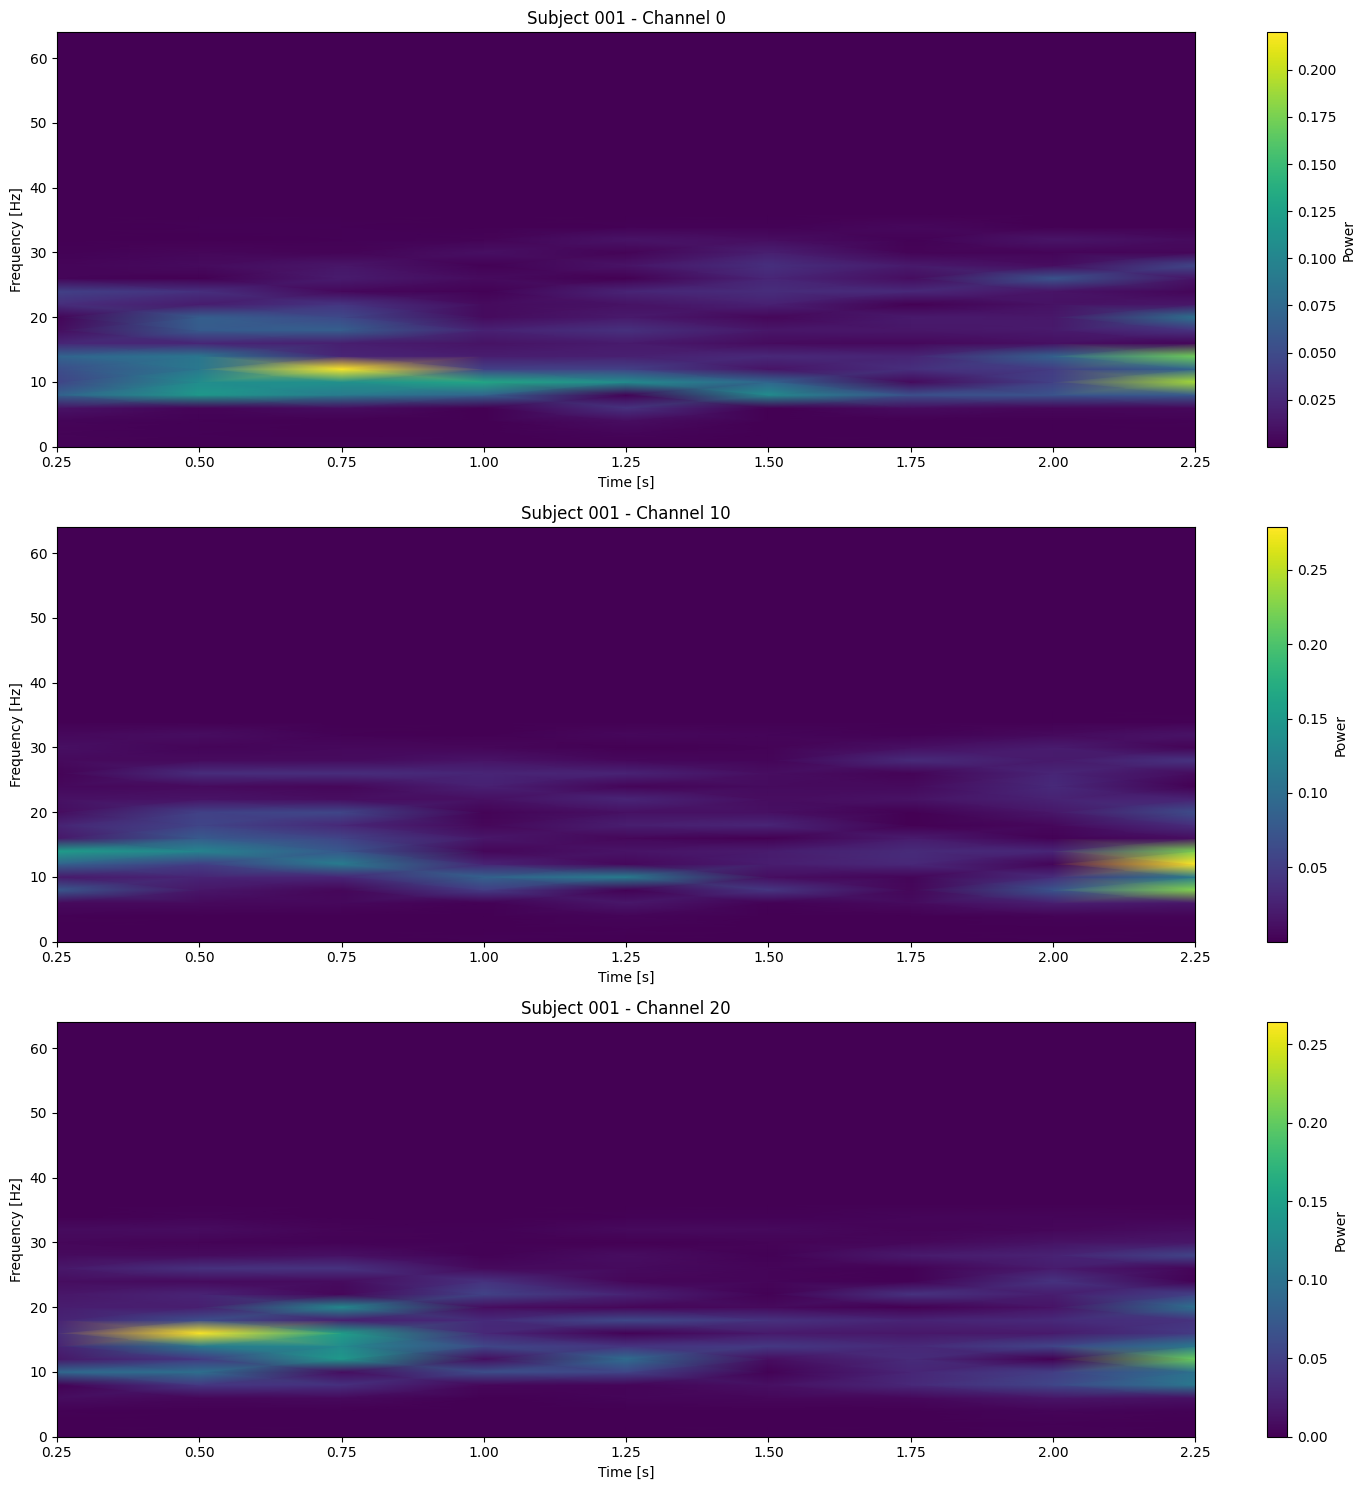

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Pick one subject to visualize
subject_id = 0  # 0-indexed (S001)
data = np.load(f"/content/drive/MyDrive/mne_data/preprocessed/S{subject_id+1:03d}.npz")

# Use first epoch from X
X_epoch = data['X'][0]  # shape: (channels, time)
sfreq = 128  # after resampling in preprocessing

# Plot spectrogram for a few channels
channels_to_plot = [0, 10, 20]  # first, middle, last channel
plt.figure(figsize=(15,5*len(channels_to_plot)))

for i, ch_idx in enumerate(channels_to_plot):
    f, t, Sxx = spectrogram(X_epoch[ch_idx], fs=sfreq, nperseg=64, noverlap=32)
    plt.subplot(len(channels_to_plot), 1, i+1)
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.ylabel("Frequency [Hz]")
    plt.xlabel("Time [s]")
    plt.title(f"Subject {subject_id+1:03d} - Channel {ch_idx}")
    plt.colorbar(label='Power')

plt.tight_layout()
plt.show()


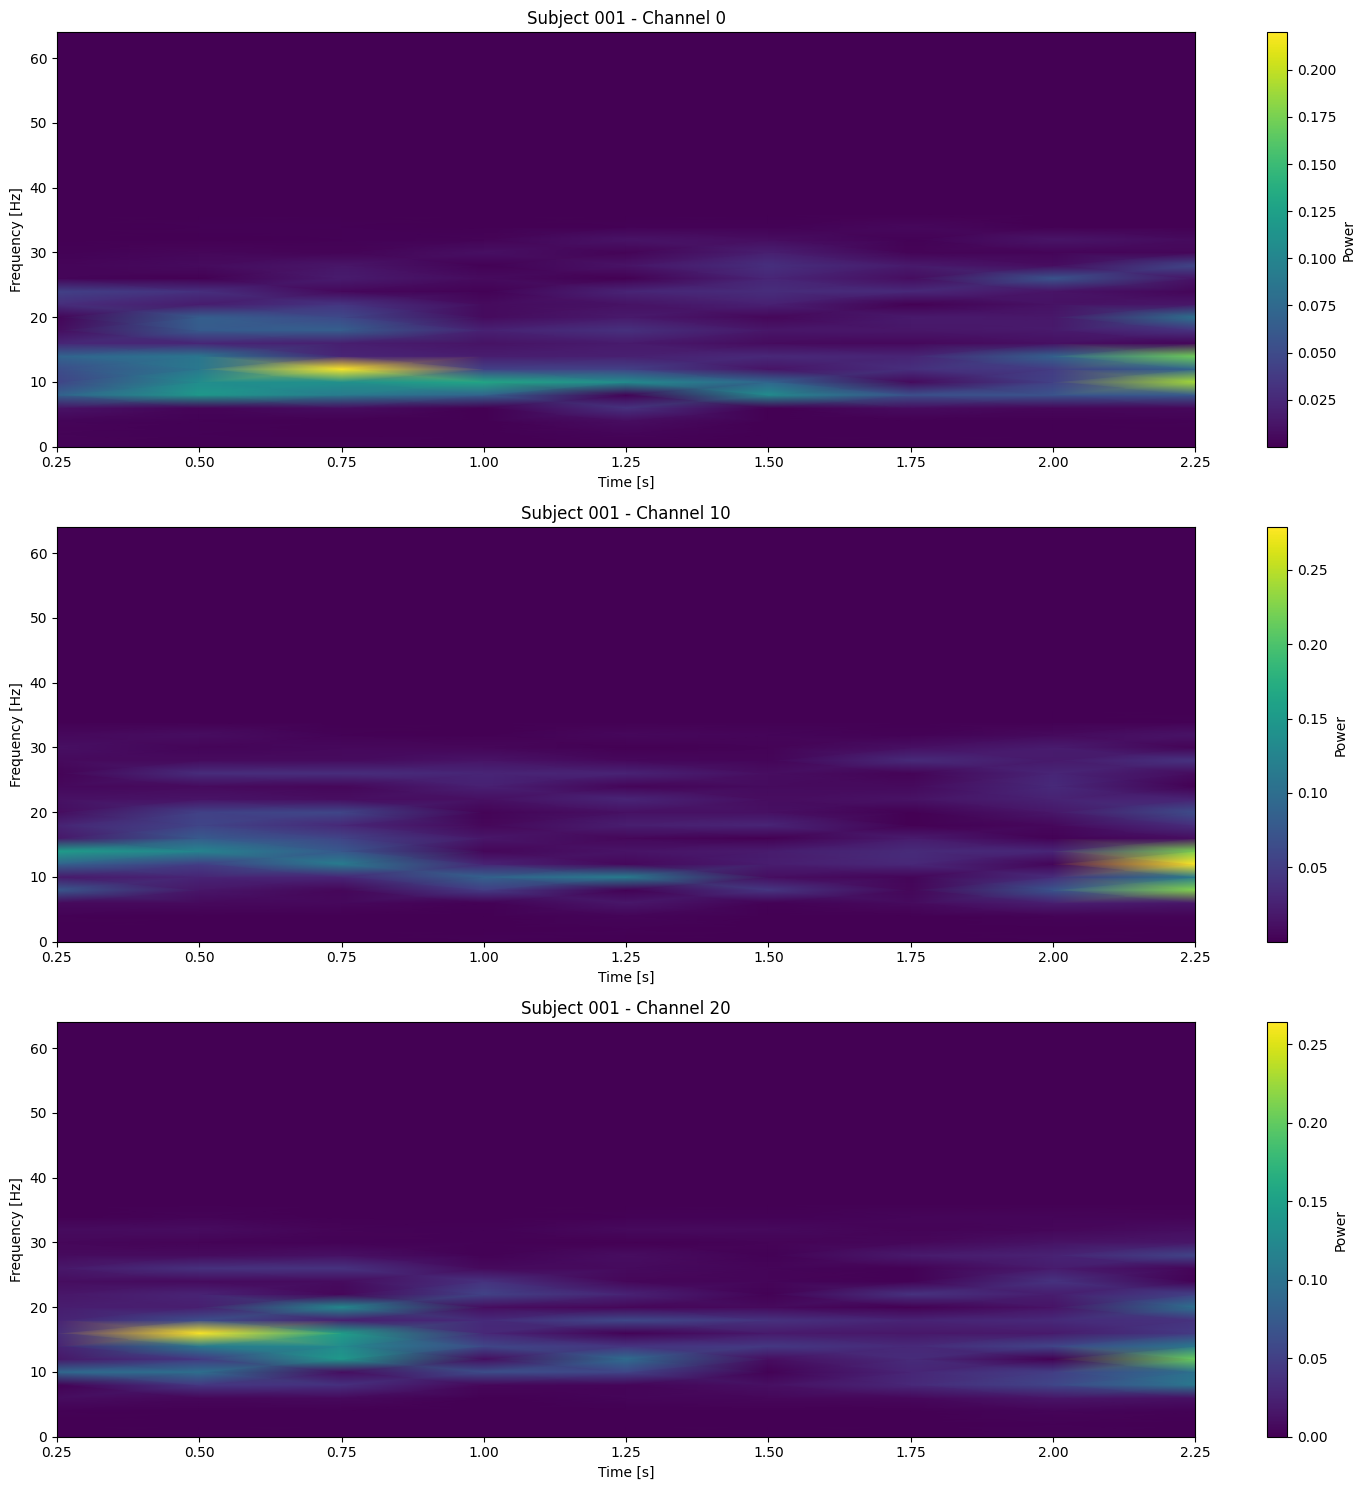

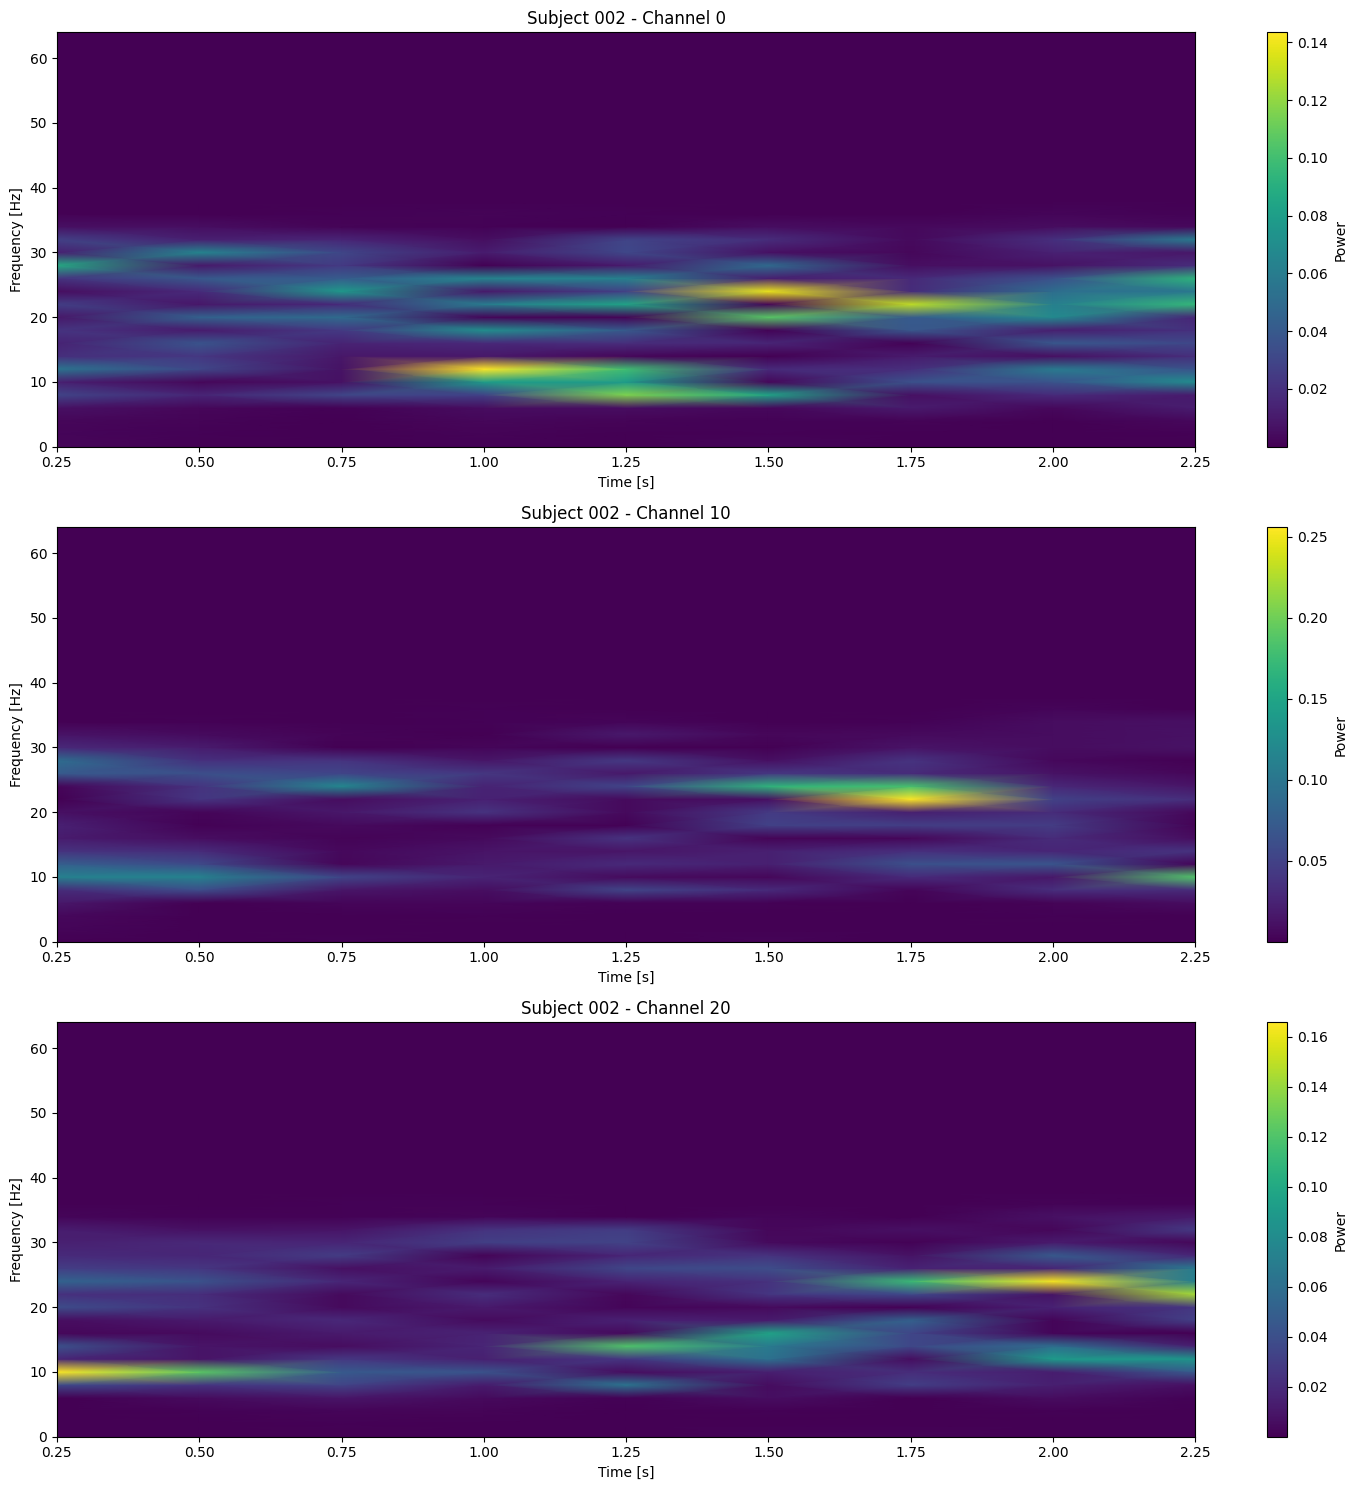

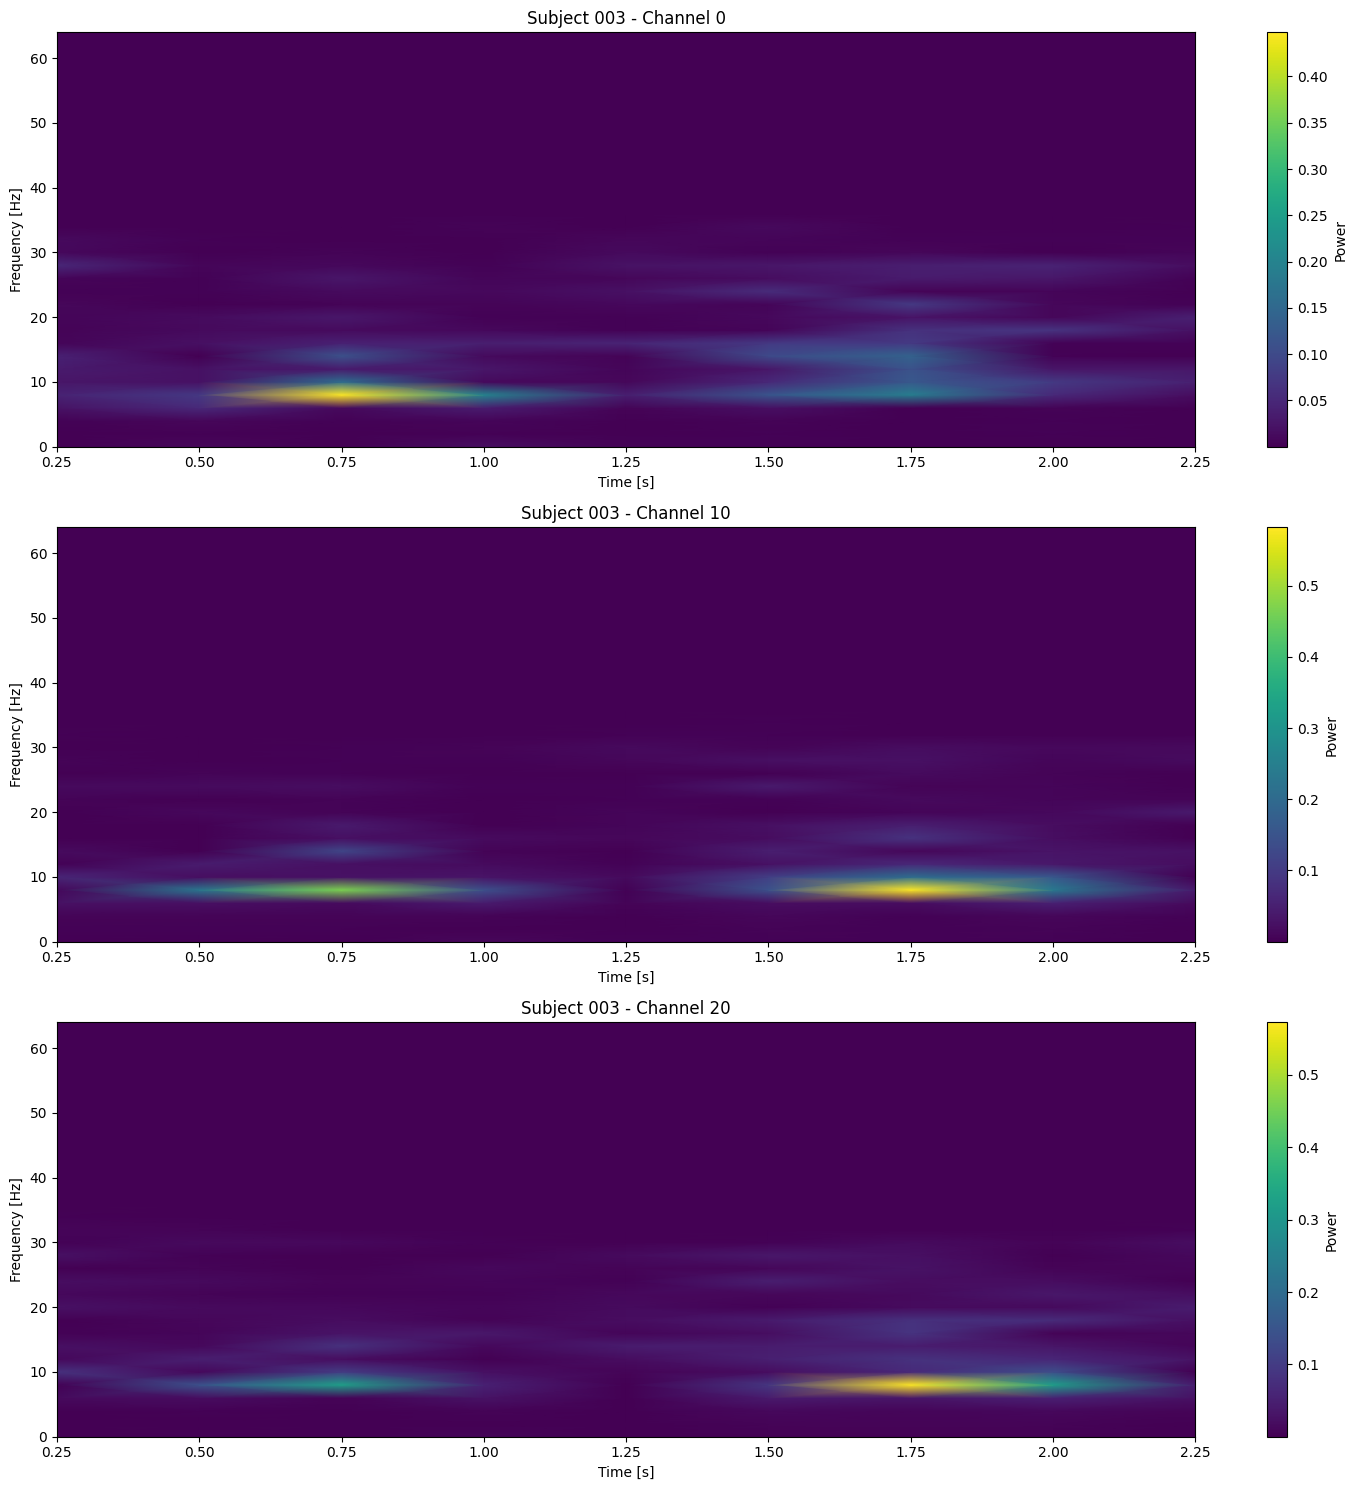

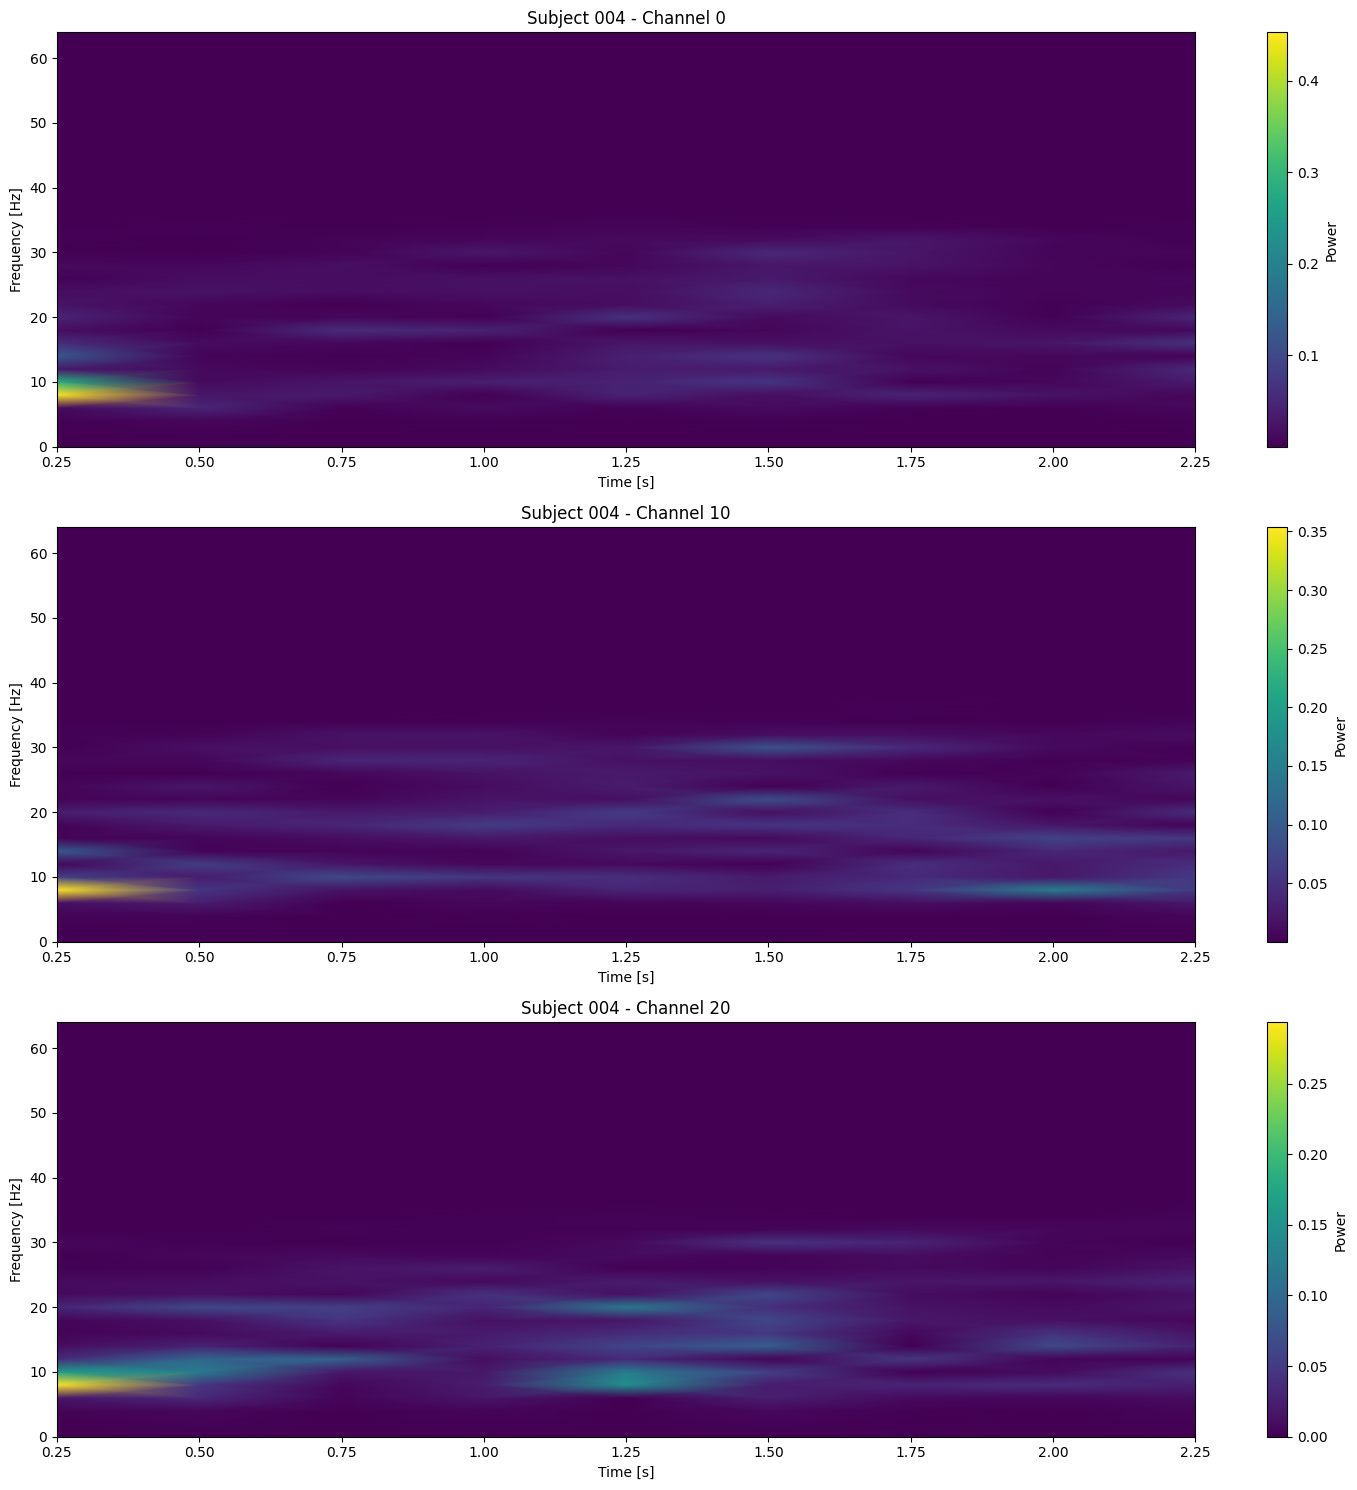

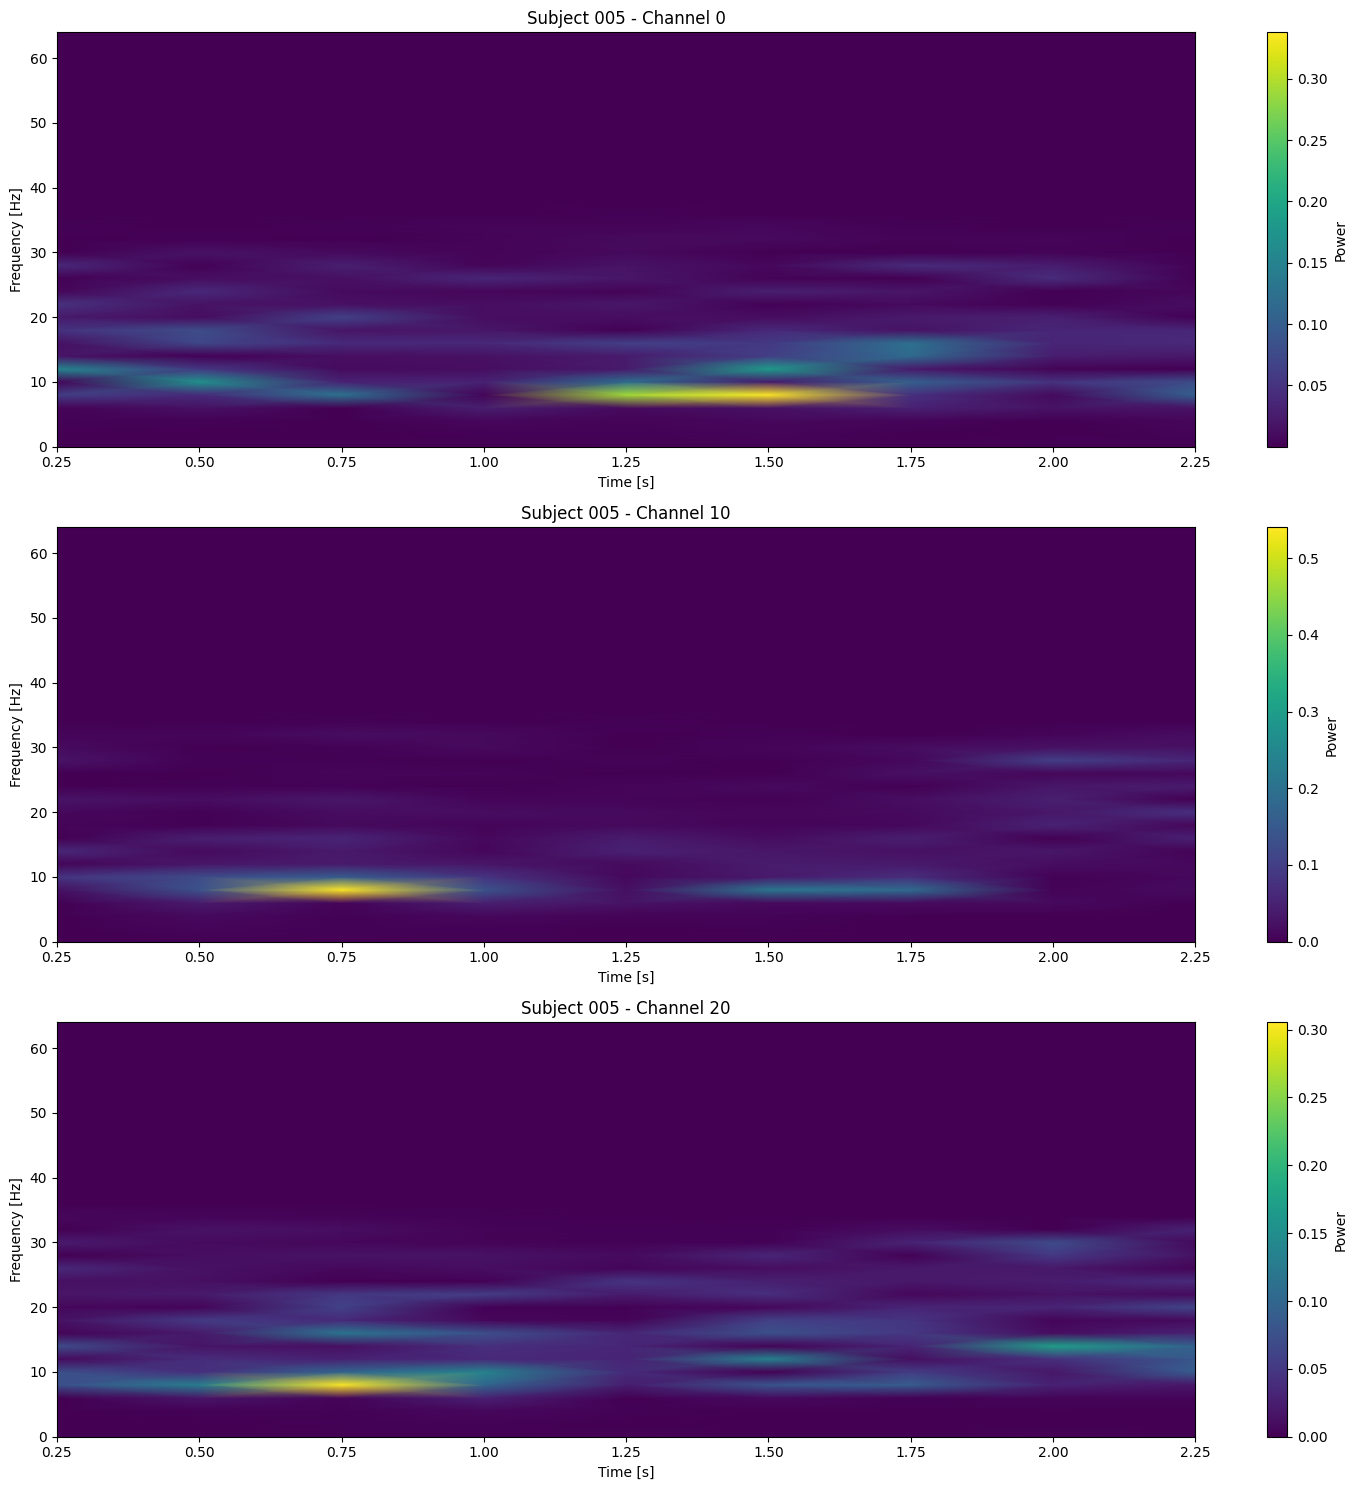

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import os

PREP_PATH = "/content/drive/MyDrive/mne_data/preprocessed"
sfreq = 128  # after preprocessing

# Channels to visualize
channels_to_plot = [0, 10, 20]  # adjust as needed

# List of subjects (for example, first 5 subjects)
subject_ids = [0, 1, 2, 3, 4]  # 0-indexed

for subject_id in subject_ids:
    data_path = os.path.join(PREP_PATH, f"S{subject_id+1:03d}.npz")
    data = np.load(data_path)
    X_epoch = data['X'][0]  # first epoch

    plt.figure(figsize=(15,5*len(channels_to_plot)))
    for i, ch_idx in enumerate(channels_to_plot):
        f, t, Sxx = spectrogram(X_epoch[ch_idx], fs=sfreq, nperseg=64, noverlap=32)
        plt.subplot(len(channels_to_plot), 1, i+1)
        plt.pcolormesh(t, f, Sxx, shading='gouraud')
        plt.ylabel("Frequency [Hz]")
        plt.xlabel("Time [s]")
        plt.title(f"Subject {subject_id+1:03d} - Channel {ch_idx}")
        plt.colorbar(label='Power')

    plt.tight_layout()
    plt.show()


In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 4.4 MB/s eta 0:00:00


In [ ]:
import optuna
import torch.nn as nn
import torch.optim as optim

def objective(trial):
    # Hyperparameters to tune
    cnn_channels = trial.suggest_categorical('cnn_channels', [64, 128, 256])
    rnn_hidden = trial.suggest_categorical('rnn_hidden', [64, 128, 256])
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # DataLoader with suggested batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Build model
    model = EEG_CNN_RNN(n_channels=X_train.shape[1], n_times=X_train.shape[2],
                        n_classes=109, rnn_hidden=rnn_hidden)
    model.to(device)

    # Loss & optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Quick training: 5 epochs for tuning
    for epoch in range(5):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Validation accuracy
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = outputs.max(1)
            val_total += y_batch.size(0)
            val_correct += predicted.eq(y_batch).sum().item()

    val_acc = val_correct / val_total
    return val_acc


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # adjust n_trials for longer search

print("Best trial:")
trial = study.best_trial
print(trial.params)

[I 2025-11-21 18:45:59,398] A new study created in memory with name: no-name-d150b64e-4e08-4c2c-bad0-e50a30a371c1
/tmp/ipython-input-4026916167.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
[I 2025-11-21 19:02:30,520] Trial 0 finished with value: 0.23233350279613624 and parameters: {'cnn_channels': 64, 'rnn_hidden': 64, 'dropout': 0.20891359631385353, 'lr': 0.00021755700533289296, 'batch_size': 32}. Best is trial 0 with value: 0.23233350279613624.
[I 2025-11-21 19:22:44,179] Trial 1 finished with value: 0.8505338078291815 and parameters: {'cnn_channels': 256, 'rnn_hidden': 128, 'dropout': 0.24020872486877806, 'lr': 0.0009834778574604127, 'batch_size': 32}. Best is trial 1 with value: 0.8505338078291815.
[I 2025-11-21 19:34:58,992] Trial 2 finished with value: 0.766649720386

Best trial:
{'cnn_channels': 256, 'rnn_hidden': 128, 'dropout': 0.24020872486877806, 'lr': 0.0009834778574604127, 'batch_size': 32}


In [1]:
best_params = trial.params

model = EEG_CNN_RNN(
    n_channels=X_train.shape[1],
    n_times=X_train.shape[2],
    n_classes=109,
    rnn_hidden=best_params['rnn_hidden']
)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
BATCH_SIZE = best_params['batch_size']
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


NameError: name 'trial' is not defined